# Neural Network Analysis

**Author**: Maleakhi Agung Wijaya  
**Email**: *maw219@cam.ac.uk*  
**Description**: This file contains code implementation of various neural networks, including 2D-CNNPred, 3D-CNNPred, shallow feedforward network, and RNN-based network.

In [383]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_absolute_error as mae
import os
from pathlib2 import Path
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import layers, models, backend as K, callbacks

In [384]:
%run Utilities.ipynb

## Load data and preprocessing

In this step, we will load all dataframes,fill missing values, and scale so that each column all features are on the same scale. Afterwards, we will generate sequential datasets using **full features, PCA features**, and only **technical indicator features**.

In [385]:
market_orders, n_markets, aggregated_datasets = load_aggregated_datasets([ 
                                                                         
                                                                          DATASET_AAPL,
                                                                          DATASET_MSFT,
                                                                          DATASET_AMZN])

## AAPL
aapl_df = aggregated_datasets["AAPL"]

## AMZN
amzn_df = aggregated_datasets["AMZN"]

## MSFT
msft_df = aggregated_datasets["MSFT"]

In [386]:
aapl_df.columns

Index(['Open', 'Close', 'Adj Close', 'Volume', 'Down-F', 'Sp500', 'Nasdaq',
       'Russel', 'Gold', 'Silver', 'Eur_usd', 'Nikkei', 'Gpb_usd', 'Usd_jpy',
       'Fste', 'Sugar', 'Nat_Gas', 'Corn-F', 'Coffe-F', 'Feeder-F', 'Vix',
       'Tnx', 'Bzf', 'Upper_bb', 'Middle_bb', 'Lower_bb', 'Sma', 'Mom5',
       'Mom10', 'Mom15', 'Mom20', 'Slow_k', 'Slow_d', 'Fast_k', 'Fast_d',
       'Trix', 'William_R', 'Rocr', 'Pro', 'Mfi', 'Macd', 'Macd_sig', 'Apo',
       'Aroon_up', 'Aroon_down', 'Cci', 'Cmo', 'Dx', 'Ultosc', 'MOVEMENT'],
      dtype='object')

In [6]:
## DO NOT RUN BELOW FOR 3D CNN PRED
# Fill missing values, do some scaling (run prev cell first)
list_df = []

for df in [aapl_df, msft_df, amzn_df]:
    columns = df.columns
    df.fillna(0, inplace=True) # fill na with 0
    y = df["MOVEMENT"].copy()
    X = df.drop(columns=["MOVEMENT"]).copy()
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X))
    X["MOVEMENT"] = np.array(y)
    X.columns = columns
    list_df.append(X)
    
aapl_df_full = list_df[0]
msft_df_full = list_df[1]
amzn_df_full = list_df[2]

In [8]:
def feature_select(df, min):
    rfecv = RFECV(estimator=LogisticRegression(), step =1, min_features_to_select=min, cv=5, scoring='accuracy')
    y = df["MOVEMENT"].copy()
    X = df.drop(columns=["MOVEMENT"]).copy()
    selector = rfecv.fit(df.drop(columns=["MOVEMENT"]), df["MOVEMENT"])
    print("Optimal number of features: ", rfecv.n_features_)
    selected_rfe_features = pd.DataFrame({'Feature':list(X.columns), 'Ranking': selector.ranking_})
    selected_rfe_features.sort_values(by='Ranking',inplace=True)
    print(selected_rfe_features.head(rfecv.n_features_))
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (accuracy)")
    plt.plot(range(min, len(rfecv.grid_scores_) + min), rfecv.grid_scores_)
    plt.show()
    reduced_X = pd.DataFrame(selector.transform(X))
    reduced_X["MOVEMENT"] = y
    return reduced_X

In [9]:
# High Correlation
cor_columns = [
    "Open", "Close", "Adj Close", "Lower_bb",
    "Sma", "Macd"
]

# cor_columns = [
#     "Nasdaq", "Silver", "Nat_Gas", "Mom15",
#     "Mom20", "Fast_d", "Mfi", "Macd_sig",
#     "Apo", "Ultosc", 
# ]

# cor_columns = [
#     "Mom20", "Gpb_usd", "Cci", "Dx",
#     "Apo", "Fste", "Pro", "Fast_d", "Slow_d",
# ]

list_df_cor = []

for df in [aapl_df_full, msft_df_full, amzn_df_full]:
    y = df["MOVEMENT"].copy()
    X = df[cor_columns].copy()
    X["MOVEMENT"] = np.array(y)
    list_df_cor.append(X)

### Clean dataframe (ti features)
aapl_df_cor = list_df_cor[0]
msft_df_cor = list_df_cor[1]
amzn_df_cor = list_df_cor[2]

Optimal number of features:  6
      Feature  Ranking
0        Open        1
1       Close        1
2   Adj Close        1
26        Sma        1
40       Macd        1
25   Lower_bb        1


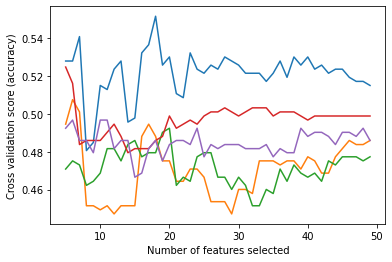

Optimal number of features:  13
      Feature  Ranking
48     Ultosc        1
28      Mom10        1
32     Slow_d        1
33     Fast_k        1
25   Lower_bb        1
36  William_R        1
40       Macd        1
34     Fast_d        1
5       Sp500        1
45        Cci        1
1       Close        1
42        Apo        1
23   Upper_bb        1


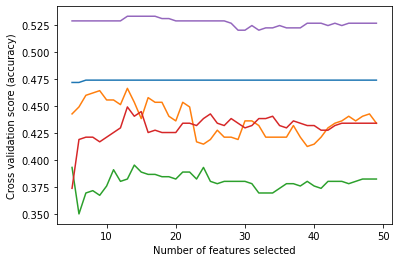

Optimal number of features:  5
     Feature  Ranking
0       Open        1
23  Upper_bb        1
25  Lower_bb        1
4     Down-F        1
8       Gold        1


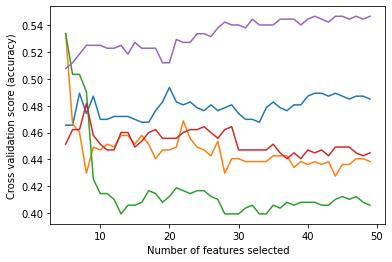

In [10]:
# PCA dataframe (30 features - explained 90% variance) - pca.explained_variance_ratio_.cumsum()
list_df_pca = []

columns_pca = [
    "Open", "Close", "Adj Close", "Lower_bb",
    "Sma", "Macd" 
]

# columns_pca = [
#     "Open", "Close", "Adj Close", "Lower_bb",
#     "Sma", "Macd" , "Down-F" , "Russel" ,"Gold" ,"Upper_bb" ,"Down-F" , "Mom10" , "Mom15" , "Rocr" , "Pro" , "Apo" , "Cci" ,
# ]

for df in [aapl_df_full, msft_df_full, amzn_df_full]:
    cur_df = df.copy()
    cur_df = feature_select(cur_df , 5)
    pca = PCA(n_components= 1)
    y = cur_df["MOVEMENT"].copy()
    X = cur_df.drop(columns=["MOVEMENT"]).copy()
    reduced_X = pd.DataFrame(pca.fit_transform(X))
    reduced_X["MOVEMENT"] = y
    list_df_pca.append(reduced_X)

aapl_df_pca = list_df_pca[0]
msft_df_pca = list_df_pca[1]
amzn_df_pca = list_df_pca[2]

In [39]:
# Technical indicator dataframe

list_df_ti = []

for df in [aapl_df_full, msft_df_full, amzn_df_full]:
    y = df["MOVEMENT"].copy()
    X = df[list(df.columns)[24:49]].copy()
    X["MOVEMENT"] = np.array(y)
    list_df_ti.append(X)

### Clean dataframe (ti features)
aapl_df_ti = list_df_ti[0]
msft_df_ti = list_df_ti[1]
amzn_df_ti = list_df_ti[2]


In [40]:
# Build sequential dataset
sequence_length = 30

### Sequential dataset (full features)
aapl_X_seq, aapl_y_seq = generate_sequential_data(aapl_df_full, sequence_length)
msft_X_seq, msft_y_seq = generate_sequential_data(msft_df_full, sequence_length)
amzn_X_seq, amzn_y_seq = generate_sequential_data(amzn_df_full, sequence_length)

In [41]:
### Sequential dataset (PCA features)
aapl_X_pca_seq, aapl_y_pca_seq = generate_sequential_data(aapl_df_pca, sequence_length)
msft_X_pca_seq, msft_y_pca_seq = generate_sequential_data(msft_df_pca, sequence_length)
amzn_X_pca_seq, amzn_y_pca_seq = generate_sequential_data(amzn_df_pca, sequence_length)


In [42]:
### Sequential dataset (TI features)
aapl_X_ti_seq, aapl_y_ti_seq = generate_sequential_data(aapl_df_ti, sequence_length)
msft_X_ti_seq, msft_y_ti_seq = generate_sequential_data(msft_df_ti, sequence_length)
amzn_X_ti_seq, amzn_y_ti_seq = generate_sequential_data(amzn_df_ti, sequence_length)

In [43]:
### Sequential dataset (TI features)
aapl_X_cor_seq, aapl_y_cor_seq = generate_sequential_data(aapl_df_cor, sequence_length)
msft_X_cor_seq, msft_y_cor_seq = generate_sequential_data(msft_df_cor, sequence_length)
amzn_X_cor_seq, amzn_y_cor_seq = generate_sequential_data(amzn_df_cor, sequence_length)

## 2D CNNpred

In this section, we will implement a 2D CNNpred from the paper.

### Load data

In [44]:
# Sequential flatten (full features)
aapl_X_seq_flatten = sequential_reshape(aapl_X_seq, (len(aapl_X_seq), sequence_length, -1, 1))
msft_X_seq_flatten = sequential_reshape(msft_X_seq, (len(msft_X_seq), sequence_length, -1, 1))
amzn_X_seq_flatten = sequential_reshape(amzn_X_seq, (len(amzn_X_seq), sequence_length, -1, 1))


In [45]:
# Sequential flatten (pca)
aapl_X_pca_seq_flatten = sequential_reshape(aapl_X_pca_seq, (len(aapl_X_seq), sequence_length, -1, 1))
msft_X_pca_seq_flatten = sequential_reshape(msft_X_pca_seq, (len(msft_X_seq), sequence_length, -1, 1))
amzn_X_pca_seq_flatten = sequential_reshape(amzn_X_pca_seq, (len(amzn_X_seq), sequence_length, -1, 1))


In [46]:
# Sequential flatten (technical indicator)
aapl_X_ti_seq_flatten = sequential_reshape(aapl_X_ti_seq, (len(aapl_X_seq), sequence_length, -1, 1))
msft_X_ti_seq_flatten = sequential_reshape(msft_X_ti_seq, (len(msft_X_seq), sequence_length, -1, 1))
amzn_X_ti_seq_flatten = sequential_reshape(amzn_X_ti_seq, (len(amzn_X_seq), sequence_length, -1, 1))

In [47]:
# Sequential flatten (technical indicator)
aapl_X_cor_seq_flatten = sequential_reshape(aapl_X_cor_seq, (len(aapl_X_seq), sequence_length, -1, 1))
msft_X_cor_seq_flatten = sequential_reshape(msft_X_cor_seq, (len(msft_X_seq), sequence_length, -1, 1))
amzn_X_cor_seq_flatten = sequential_reshape(amzn_X_cor_seq, (len(amzn_X_seq), sequence_length, -1, 1))

### Split into training, validation, and testing (80/10/10)

In [48]:
## Full features
aapl_X_train_full, aapl_X_test_full, aapl_y_train_full, aapl_y_test_full = train_test_split(aapl_X_seq_flatten,
                                                                                        aapl_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
aapl_X_train_full, aapl_X_valid_full, aapl_y_train_full, aapl_y_valid_full = train_test_split(aapl_X_train_full,
                                                                                        aapl_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
msft_X_train_full, msft_X_test_full, msft_y_train_full, msft_y_test_full = train_test_split(msft_X_seq_flatten,
                                                                                        msft_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
msft_X_train_full, msft_X_valid_full, msft_y_train_full, msft_y_valid_full = train_test_split(msft_X_train_full,
                                                                                        msft_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1,
                                                                                        shuffle=False)
amzn_X_train_full, amzn_X_test_full, amzn_y_train_full, amzn_y_test_full = train_test_split(amzn_X_seq_flatten,
                                                                                        amzn_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
amzn_X_train_full, amzn_X_valid_full, amzn_y_train_full, amzn_y_valid_full = train_test_split(amzn_X_train_full,
                                                                                        amzn_y_train_full,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)


In [49]:
aapl_X_train_full.shape

(1852, 30, 49, 1)

In [50]:
aapl_X_valid_full.shape

(206, 30, 49, 1)

In [51]:
aapl_X_test_full.shape

(229, 30, 49, 1)

In [52]:
## pca features
aapl_X_train_pca, aapl_X_test_pca, aapl_y_train_pca, aapl_y_test_pca = train_test_split(aapl_X_pca_seq_flatten,
                                                                                        aapl_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
aapl_X_train_pca, aapl_X_valid_pca, aapl_y_train_pca, aapl_y_valid_pca = train_test_split(aapl_X_train_pca,
                                                                                        aapl_y_train_pca,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
msft_X_train_pca, msft_X_test_pca, msft_y_train_pca, msft_y_test_pca = train_test_split(msft_X_pca_seq_flatten,
                                                                                        msft_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
msft_X_train_pca, msft_X_valid_pca, msft_y_train_pca, msft_y_valid_pca = train_test_split(msft_X_train_pca,
                                                                                        msft_y_train_pca,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
amzn_X_train_pca, amzn_X_test_pca, amzn_y_train_pca, amzn_y_test_pca = train_test_split(amzn_X_pca_seq_flatten,
                                                                                        amzn_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
amzn_X_train_pca, amzn_X_valid_pca, amzn_y_train_pca, amzn_y_valid_pca = train_test_split(amzn_X_train_pca,
                                                                                        amzn_y_train_pca,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)


In [53]:
## ti features
aapl_X_train_ti, aapl_X_test_ti, aapl_y_train_ti, aapl_y_test_ti = train_test_split(aapl_X_ti_seq_flatten,
                                                                                        aapl_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
aapl_X_train_ti, aapl_X_valid_ti, aapl_y_train_ti, aapl_y_valid_ti = train_test_split(aapl_X_train_ti,
                                                                                        aapl_y_train_ti,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
msft_X_train_ti, msft_X_test_ti, msft_y_train_ti, msft_y_test_ti = train_test_split(msft_X_ti_seq_flatten,
                                                                                        msft_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
msft_X_train_ti, msft_X_valid_ti, msft_y_train_ti, msft_y_valid_ti = train_test_split(msft_X_train_ti,
                                                                                        msft_y_train_ti,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
amzn_X_train_ti, amzn_X_test_ti, amzn_y_train_ti, amzn_y_test_ti = train_test_split(amzn_X_ti_seq_flatten,
                                                                                        amzn_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
amzn_X_train_ti, amzn_X_valid_ti, amzn_y_train_ti, amzn_y_valid_ti = train_test_split(amzn_X_train_ti,
                                                                                        amzn_y_train_ti,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)


In [54]:
## pca features
aapl_X_train_cor, aapl_X_test_cor, aapl_y_train_cor, aapl_y_test_cor = train_test_split(aapl_X_cor_seq_flatten,
                                                                                        aapl_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
aapl_X_train_cor, aapl_X_valid_cor, aapl_y_train_cor, aapl_y_valid_cor = train_test_split(aapl_X_train_cor,
                                                                                        aapl_y_train_cor,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
msft_X_train_cor, msft_X_test_cor, msft_y_train_cor, msft_y_test_cor = train_test_split(msft_X_cor_seq_flatten,
                                                                                        msft_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
msft_X_train_cor, msft_X_valid_cor, msft_y_train_cor, msft_y_valid_cor = train_test_split(msft_X_train_cor,
                                                                                        msft_y_train_cor,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
amzn_X_train_cor, amzn_X_test_cor, amzn_y_train_cor, amzn_y_test_cor = train_test_split(amzn_X_cor_seq_flatten,
                                                                                        amzn_y_seq,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)
amzn_X_train_cor, amzn_X_valid_cor, amzn_y_train_cor, amzn_y_valid_cor = train_test_split(amzn_X_train_cor,
                                                                                        amzn_y_train_cor,
                                                                                        stratify=None,
                                                                                        test_size=0.1, shuffle=False)


### Combine datasets

In [55]:
# full
# Train
X_train_full = np.concatenate(
    (aapl_X_train_full,
     msft_X_train_full,
     amzn_X_train_full,
    )
)
y_train_full = np.concatenate(
    (np.array(aapl_y_train_full),
     np.array(msft_y_train_full),
     np.array(amzn_y_train_full),
     
    )
)

# Valid
X_valid_full = np.concatenate(
    (aapl_X_valid_full,
     msft_X_valid_full,
     amzn_X_valid_full,
     )
)
y_valid_full = np.concatenate(
    (np.array(aapl_y_valid_full),
     np.array(msft_y_valid_full),
     np.array(amzn_y_valid_full),
     
    )
)

In [56]:
# pca
# Train
X_train_pca = np.concatenate(
    (aapl_X_train_pca,
     msft_X_train_pca,
     amzn_X_train_pca,
    )
)
y_train_pca = np.concatenate(
    (np.array(aapl_y_train_pca),
     np.array(msft_y_train_pca),
     np.array(amzn_y_train_pca),
     
    )
)

# Valid
X_valid_pca = np.concatenate(
    (aapl_X_valid_pca,
     msft_X_valid_pca,
     amzn_X_valid_pca,
    )
)
y_valid_pca = np.concatenate(
    (np.array(aapl_y_valid_pca),
     np.array(msft_y_valid_pca),
     np.array(amzn_y_valid_pca),
     
    )
)

In [57]:
# ti
# Train
X_train_ti = np.concatenate(
    (aapl_X_train_ti,
     msft_X_train_ti,
     amzn_X_train_ti,
     )
)
y_train_ti = np.concatenate(
    (np.array(aapl_y_train_ti),
     np.array(msft_y_train_ti),
     np.array(amzn_y_train_ti),
     
    )
)

# Valid
X_valid_ti = np.concatenate(
    (aapl_X_valid_ti,
     msft_X_valid_ti,
     amzn_X_valid_ti,
     )
)
y_valid_ti = np.concatenate(
    (np.array(aapl_y_valid_ti),
     np.array(msft_y_valid_ti),
     np.array(amzn_y_valid_ti),
     
    )
)

In [58]:
# cor
# Train
X_train_cor = np.concatenate(
    (aapl_X_train_cor,
     msft_X_train_cor,
     amzn_X_train_cor,
     )
)
y_train_cor = np.concatenate(
    (np.array(aapl_y_train_cor),
     np.array(msft_y_train_cor),
     np.array(amzn_y_train_cor),
     
    )
)

# Valid
X_valid_cor = np.concatenate(
    (aapl_X_valid_cor,
     msft_X_valid_cor,
     amzn_X_valid_cor,
     )
)
y_valid_cor = np.concatenate(
    (np.array(aapl_y_valid_cor),
     np.array(msft_y_valid_cor),
     np.array(amzn_y_valid_cor),
     
    )
)

In [59]:
X_train_cor.shape

(5556, 30, 6, 1)

### Model training and evaluation

#### Full features

In [60]:
X_valid_full.shape

(618, 30, 49, 1)

In [61]:
model_full = cnnpred_2d(30, 49, [8, 8, 8])
epochs = 200
batch_size=128

## Training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model_full.compile(optimizer="Adam", loss="binary_crossentropy", 
                   metrics=["acc", f1])
model_full.fit(X_train_full, y_train_full, epochs=epochs,
              batch_size=batch_size, callbacks=[early_stopping],
              validation_data=(X_valid_full, y_valid_full))

Epoch 1/200
44/44 [==============================] - 1s 11ms/step - loss: 0.6944 - acc: 0.5031 - f1: 0.4470 - val_loss: 0.6912 - val_acc: 0.5453 - val_f1: 0.3823
Epoch 2/200
44/44 [==============================] - 0s 7ms/step - loss: 0.6907 - acc: 0.5250 - f1: 0.4092 - val_loss: 0.6900 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 3/200
44/44 [==============================] - 0s 7ms/step - loss: 0.6892 - acc: 0.5448 - f1: 0.4940 - val_loss: 0.6908 - val_acc: 0.5405 - val_f1: 0.5133
Epoch 4/200
44/44 [==============================] - 0s 7ms/step - loss: 0.6863 - acc: 0.5488 - f1: 0.5035 - val_loss: 0.6915 - val_acc: 0.5372 - val_f1: 0.5003
Epoch 5/200
44/44 [==============================] - 0s 7ms/step - loss: 0.6827 - acc: 0.5554 - f1: 0.5188 - val_loss: 0.6931 - val_acc: 0.5405 - val_f1: 0.4147
Epoch 6/200
44/44 [==============================] - 0s 6ms/step - loss: 0.6799 - acc: 0.5551 - f1: 0.5472 - val_loss: 0.7058 - val_acc: 0.5210 - val_f1: 0.4759
Epoch 7/200
44/44 [==============

In [62]:
## aapl
result_aapl_full = model_full.predict(aapl_X_test_full)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_full, aapl_y_test_full)}")
print(f"aapl F1: {f1_score(result_aapl_full, aapl_y_test_full, average='macro')}")

aapl Accuracy: 0.49344978165938863
aapl F1: 0.48733981781689056


In [63]:
## msft
result_msft_full = model_full.predict(msft_X_test_full)
result_msft_full = (result_msft_full > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_msft_full, msft_y_test_full)}")
print(f"msft F1: {f1_score(result_msft_full, msft_y_test_full, average='macro')}")

msft Accuracy: 0.519650655021834
msft F1: 0.5094640909799034


In [64]:
## amzn
result_amzn_full = model_full.predict(amzn_X_test_full)
result_amzn_full = (result_amzn_full > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_amzn_full, amzn_y_test_full)}")
print(f"amzn F1: {f1_score(result_amzn_full, amzn_y_test_full, average='macro')}")

amzn Accuracy: 0.4585152838427948
amzn F1: 0.4582570207570208


              precision    recall  f1-score   support

           0       0.45      0.42      0.43       106
           1       0.53      0.56      0.54       123

    accuracy                           0.49       229
   macro avg       0.49      0.49      0.49       229
weighted avg       0.49      0.49      0.49       229



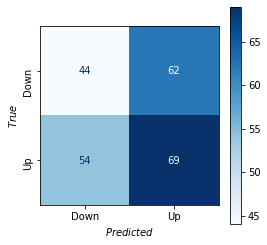

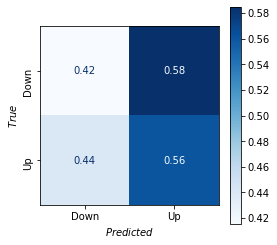

In [65]:
## AAPL
print(classification_report(result_aapl_full, aapl_y_test_full))
plot_confusion_matrix(result_aapl_full, aapl_y_test_full, labels=["Down", "Up"])

#### PCA features

In [68]:
model_pca = cnnpred_2d(30, 1, [1, 1, 1])
epochs = 200
batch_size = 128

## Training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model_pca.compile(optimizer="Adam", loss="mae", 
                   metrics=["acc", f1])
model_pca.fit(X_train_pca, y_train_pca, epochs=epochs,
              batch_size=batch_size, callbacks=[early_stopping],
              validation_data=(X_valid_pca, y_valid_pca))

Epoch 1/200
44/44 [==============================] - 1s 12ms/step - loss: 0.4984 - acc: 0.5124 - f1: 0.3709 - val_loss: 0.4752 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 2/200
44/44 [==============================] - 0s 6ms/step - loss: 0.4867 - acc: 0.5230 - f1: 0.3434 - val_loss: 0.4535 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 3/200
44/44 [==============================] - 0s 6ms/step - loss: 0.4795 - acc: 0.5229 - f1: 0.3422 - val_loss: 0.4518 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 4/200
44/44 [==============================] - 0s 6ms/step - loss: 0.4779 - acc: 0.5229 - f1: 0.3428 - val_loss: 0.4516 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 5/200
44/44 [==============================] - 0s 6ms/step - loss: 0.4776 - acc: 0.5229 - f1: 0.3422 - val_loss: 0.4515 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 6/200
44/44 [==============================] - 0s 5ms/step - loss: 0.4773 - acc: 0.5229 - f1: 0.3423 - val_loss: 0.4515 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 7/200
44/44 [==============

In [69]:
## aapl
result_aapl_pca = model_pca.predict(aapl_X_test_pca)
result_aapl_pca = (result_aapl_pca > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_pca, aapl_y_test_pca)}")
print(f"aapl F1: {f1_score(result_aapl_pca, aapl_y_test_pca, average='macro')}")

aapl Accuracy: 0.5720524017467249
aapl F1: 0.3638888888888889


In [70]:
## msft
result_msft_pca = model_pca.predict(msft_X_test_pca)
result_msft_pca = (result_msft_pca > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_msft_pca, msft_y_test_pca)}")
print(f"msft F1: {f1_score(result_msft_pca, msft_y_test_pca, average='macro')}")

msft Accuracy: 0.5807860262008734
msft F1: 0.41841269841269835


In [72]:
## amzn
result_amzn_pca = model_pca.predict(amzn_X_test_pca)
result_amzn_pca = (result_amzn_pca > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_amzn_pca, amzn_y_test_pca)}")
print(f"amzn F1: {f1_score(result_amzn_pca, amzn_y_test_pca, average='macro')}")

amzn Accuracy: 0.5283842794759825
amzn F1: 0.3457142857142857


#### Technical indicator features

In [73]:
model_ti = cnnpred_2d(30, X_train_ti.shape[2], [8, 8, 8])
epochs = 200
batch_size=128

## Training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model_ti.compile(optimizer="Adam", loss="mae", 
                   metrics=["acc", f1])
model_ti.fit(X_train_ti, y_train_ti, epochs=epochs,
              batch_size=batch_size, callbacks=[early_stopping],
              validation_data=(X_valid_ti, y_valid_ti))

Epoch 1/200
44/44 [==============================] - 1s 14ms/step - loss: 0.5024 - acc: 0.4858 - f1: 0.3657 - val_loss: 0.4894 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 2/200
44/44 [==============================] - 0s 7ms/step - loss: 0.4896 - acc: 0.5230 - f1: 0.3433 - val_loss: 0.4539 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 3/200
44/44 [==============================] - 0s 6ms/step - loss: 0.4784 - acc: 0.5229 - f1: 0.3415 - val_loss: 0.4515 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 4/200
44/44 [==============================] - 0s 6ms/step - loss: 0.4775 - acc: 0.5229 - f1: 0.3424 - val_loss: 0.4515 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 5/200
44/44 [==============================] - 0s 6ms/step - loss: 0.4772 - acc: 0.5229 - f1: 0.3420 - val_loss: 0.4515 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 6/200
44/44 [==============================] - 0s 6ms/step - loss: 0.4771 - acc: 0.5229 - f1: 0.3420 - val_loss: 0.4515 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 7/200
44/44 [==============

In [74]:
## aapl
result_aapl_ti = model_ti.predict(aapl_X_test_ti)
result_aapl_ti = (result_aapl_ti > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_ti, aapl_y_test_ti)}")
print(f"aapl F1: {f1_score(result_aapl_ti, aapl_y_test_ti, average='macro')}")

aapl Accuracy: 0.5589519650655022
aapl F1: 0.5189976084017884


In [75]:
## msft
result_msft_ti = model_ti.predict(msft_X_test_ti)
result_msft_ti = (result_msft_ti > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_msft_ti, msft_y_test_ti)}")
print(f"msft F1: {f1_score(result_msft_ti, msft_y_test_ti, average='macro')}")

msft Accuracy: 0.5895196506550219
msft F1: 0.5202799072918524


In [76]:
## amzn
result_amzn_ti = model_ti.predict(amzn_X_test_ti)
result_amzn_ti = (result_amzn_ti > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_amzn_ti, amzn_y_test_ti)}")
print(f"amzn F1: {f1_score(result_amzn_ti, amzn_y_test_ti, average='macro')}")

amzn Accuracy: 0.5240174672489083
amzn F1: 0.46851910997551366


## Correlation

In [77]:
model_cor = cnnpred_2d(30, aapl_X_test_cor.shape[2], [8, 8, 8])
epochs = 200
batch_size=128

## Training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model_cor.compile(optimizer="Adam", loss="mae", 
                   metrics=["acc", f1])
model_cor.fit(X_train_cor, y_train_cor, epochs=epochs,
              batch_size=batch_size, callbacks=[early_stopping],
              validation_data=(X_valid_cor, y_valid_cor))

Epoch 1/200
44/44 [==============================] - 1s 11ms/step - loss: 0.4956 - acc: 0.5158 - f1: 0.3700 - val_loss: 0.4634 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 2/200
44/44 [==============================] - 0s 7ms/step - loss: 0.4829 - acc: 0.5229 - f1: 0.3431 - val_loss: 0.4515 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 3/200
44/44 [==============================] - 0s 7ms/step - loss: 0.4775 - acc: 0.5229 - f1: 0.3428 - val_loss: 0.4515 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 4/200
44/44 [==============================] - 0s 6ms/step - loss: 0.4775 - acc: 0.5229 - f1: 0.3423 - val_loss: 0.4515 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 5/200
44/44 [==============================] - 0s 6ms/step - loss: 0.4769 - acc: 0.5229 - f1: 0.3429 - val_loss: 0.4515 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 6/200
44/44 [==============================] - 0s 8ms/step - loss: 0.4764 - acc: 0.5229 - f1: 0.3435 - val_loss: 0.4515 - val_acc: 0.5485 - val_f1: 0.3529
Epoch 7/200
44/44 [==============

In [78]:
## aapl
result_aapl_cor = model_cor.predict(aapl_X_test_cor)
result_aapl_cor = (result_aapl_ti > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_cor, aapl_y_test_cor)}")
print(f"aapl F1: {f1_score(result_aapl_ti, aapl_y_test_ti, average='macro')}")

aapl Accuracy: 0.5589519650655022
aapl F1: 0.5189976084017884


In [79]:
## msft
result_msft_cor = model_cor.predict(msft_X_test_cor)
result_msft_cor = (result_msft_ti > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_msft_cor, msft_y_test_cor)}")
print(f"msft F1: {f1_score(result_msft_cor, msft_y_test_cor, average='macro')}")



msft Accuracy: 0.5895196506550219
msft F1: 0.5202799072918524


In [80]:
## amzn
result_amzn_cor = model_cor.predict(amzn_X_test_cor)
result_amzn_cor = (result_amzn_cor > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_amzn_cor, amzn_y_test_cor)}")
print(f"amzn F1: {f1_score(result_amzn_cor, amzn_y_test_cor, average='macro')}")

amzn Accuracy: 0.5283842794759825
amzn F1: 0.3457142857142857


## Feedforward Neural Networks

### Load data

In [81]:
# Sequential flatten (full features)
aapl_X_seq_flatten = sequential_reshape(aapl_X_seq, (len(aapl_X_seq), -1))
msft_X_seq_flatten = sequential_reshape(msft_X_seq, (len(msft_X_seq), -1))
amzn_X_seq_flatten = sequential_reshape(amzn_X_seq, (len(amzn_X_seq), -1))


In [82]:
# Sequential flatten (pca)
aapl_X_pca_seq_flatten = sequential_reshape(aapl_X_pca_seq, (len(aapl_X_pca_seq), -1))
msft_X_pca_seq_flatten = sequential_reshape(msft_X_pca_seq, (len(msft_X_pca_seq), -1))
amzn_X_pca_seq_flatten = sequential_reshape(amzn_X_pca_seq, (len(amzn_X_pca_seq), -1))


In [83]:
# Sequential flatten (technical indicator)
aapl_X_ti_seq_flatten = sequential_reshape(aapl_X_ti_seq, (len(aapl_X_ti_seq), -1))
msft_X_ti_seq_flatten = sequential_reshape(msft_X_ti_seq, (len(msft_X_ti_seq), -1))
amzn_X_ti_seq_flatten = sequential_reshape(amzn_X_ti_seq, (len(amzn_X_ti_seq), -1))


### Split into training/validation/test (80/10/10)

In [84]:
## Full features
aapl_X_train_full, aapl_X_test_full, aapl_y_train_full, aapl_y_test_full = train_test_split(aapl_X_seq_flatten,
                                                                                        aapl_y_seq,
                                                                                        stratify=aapl_y_seq,
                                                                                        test_size=0.1,
                                                                                        shuffle=True)
aapl_X_train_full, aapl_X_valid_full, aapl_y_train_full, aapl_y_valid_full = train_test_split(aapl_X_train_full,
                                                                                        aapl_y_train_full,
                                                                                        stratify=aapl_y_train_full,
                                                                                        test_size=0.1,
                                                                                        shuffle=True)
msft_X_train_full, msft_X_test_full, msft_y_train_full, msft_y_test_full = train_test_split(msft_X_seq_flatten,
                                                                                        msft_y_seq,
                                                                                        stratify=msft_y_seq,
                                                                                        test_size=0.1,
                                                                                        shuffle=True)
msft_X_train_full, msft_X_valid_full, msft_y_train_full, msft_y_valid_full = train_test_split(msft_X_train_full,
                                                                                        msft_y_train_full,
                                                                                        stratify=msft_y_train_full,
                                                                                        test_size=0.1,
                                                                                        shuffle=True)
amzn_X_train_full, amzn_X_test_full, amzn_y_train_full, amzn_y_test_full = train_test_split(amzn_X_seq_flatten,
                                                                                        amzn_y_seq,
                                                                                        stratify=amzn_y_seq,
                                                                                        test_size=0.1, shuffle=True)
amzn_X_train_full, amzn_X_valid_full, amzn_y_train_full, amzn_y_valid_full = train_test_split(amzn_X_train_full,
                                                                                        amzn_y_train_full,
                                                                                        stratify=amzn_y_train_full,
                                                                                        test_size=0.1, shuffle=True)



In [85]:
## pca features
aapl_X_train_pca, aapl_X_test_pca, aapl_y_train_pca, aapl_y_test_pca = train_test_split(aapl_X_pca_seq_flatten,
                                                                                        aapl_y_seq,
                                                                                        stratify=aapl_y_seq,
                                                                                        test_size=0.1, shuffle=True)
aapl_X_train_pca, aapl_X_valid_pca, aapl_y_train_pca, aapl_y_valid_pca = train_test_split(aapl_X_train_pca,
                                                                                        aapl_y_train_pca,
                                                                                        stratify=aapl_y_train_pca,
                                                                                        test_size=0.1, shuffle=True)
msft_X_train_pca, msft_X_test_pca, msft_y_train_pca, msft_y_test_pca = train_test_split(msft_X_pca_seq_flatten,
                                                                                        msft_y_seq,
                                                                                        stratify=msft_y_seq,
                                                                                        test_size=0.1, shuffle=True)
msft_X_train_pca, msft_X_valid_pca, msft_y_train_pca, msft_y_valid_pca = train_test_split(msft_X_train_pca,
                                                                                        msft_y_train_pca,
                                                                                        stratify=msft_y_train_pca,
                                                                                        test_size=0.1, shuffle=True)
amzn_X_train_pca, amzn_X_test_pca, amzn_y_train_pca, amzn_y_test_pca = train_test_split(amzn_X_pca_seq_flatten,
                                                                                        amzn_y_seq,
                                                                                        stratify=amzn_y_seq,
                                                                                        test_size=0.1, shuffle=True)
amzn_X_train_pca, amzn_X_valid_pca, amzn_y_train_pca, amzn_y_valid_pca = train_test_split(amzn_X_train_pca,
                                                                                        amzn_y_train_pca,
                                                                                        stratify=amzn_y_train_pca,
                                                                                        test_size=0.1, shuffle=True)


In [86]:
## ti features
aapl_X_train_ti, aapl_X_test_ti, aapl_y_train_ti, aapl_y_test_ti = train_test_split(aapl_X_ti_seq_flatten,
                                                                                        aapl_y_seq,
                                                                                        stratify=aapl_y_seq,
                                                                                        test_size=0.1, shuffle=True)
aapl_X_train_ti, aapl_X_valid_ti, aapl_y_train_ti, aapl_y_valid_ti = train_test_split(aapl_X_train_ti,
                                                                                        aapl_y_train_ti,
                                                                                        stratify=aapl_y_train_ti,
                                                                                        test_size=0.1, shuffle=True)
msft_X_train_ti, msft_X_test_ti, msft_y_train_ti, msft_y_test_ti = train_test_split(msft_X_ti_seq_flatten,
                                                                                        msft_y_seq,
                                                                                        stratify=msft_y_seq,
                                                                                        test_size=0.1, shuffle=True)
msft_X_train_ti, msft_X_valid_ti, msft_y_train_ti, msft_y_valid_ti = train_test_split(msft_X_train_ti,
                                                                                        msft_y_train_ti,
                                                                                        stratify=msft_y_train_ti,
                                                                                        test_size=0.1, shuffle=True)
amzn_X_train_ti, amzn_X_test_ti, amzn_y_train_ti, amzn_y_test_ti = train_test_split(amzn_X_ti_seq_flatten,
                                                                                        amzn_y_seq,
                                                                                        stratify=amzn_y_seq,
                                                                                        test_size=0.1, shuffle=True)
amzn_X_train_ti, amzn_X_valid_ti, amzn_y_train_ti, amzn_y_valid_ti = train_test_split(amzn_X_train_ti,
                                                                                        amzn_y_train_ti,
                                                                                        stratify=amzn_y_train_ti,
                                                                                        test_size=0.1, shuffle=True)


### Model training and evaluation

#### Full Features

In [87]:
## aapl
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam(lr=1e-2)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(aapl_X_train_full, np.array(aapl_y_train_full), 
          epochs=200, batch_size=32,
          validation_data=(aapl_X_valid_full, np.array(aapl_y_valid_full)), callbacks=[early_stopping])

Epoch 1/200
58/58 [==============================] - 1s 5ms/step - loss: 1.1307 - acc: 0.4865 - f1: 0.4583 - val_loss: 0.7058 - val_acc: 0.5146 - val_f1: 0.4846
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 0.6980 - acc: 0.5151 - f1: 0.4835 - val_loss: 0.6956 - val_acc: 0.5485 - val_f1: 0.5121
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 0.6903 - acc: 0.5351 - f1: 0.5162 - val_loss: 0.7076 - val_acc: 0.4951 - val_f1: 0.4332
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 0.6758 - acc: 0.5491 - f1: 0.4436 - val_loss: 0.7080 - val_acc: 0.4660 - val_f1: 0.3950
Epoch 5/200
58/58 [==============================] - 0s 2ms/step - loss: 0.6819 - acc: 0.5362 - f1: 0.4420 - val_loss: 0.7045 - val_acc: 0.5000 - val_f1: 0.3830
Epoch 6/200
58/58 [==============================] - 0s 2ms/step - loss: 0.6754 - acc: 0.5448 - f1: 0.4250 - val_loss: 0.7512 - val_acc: 0.5097 - val_f1: 0.3550
Epoch 7/200
58/58 [===============

In [88]:
result_aapl_full = model.predict(aapl_X_test_full)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_full, aapl_y_test_full)}")
print(f"aapl F1: {f1_score(result_aapl_full, aapl_y_test_full, average='macro')}")

aapl Accuracy: 0.5240174672489083
aapl F1: 0.36719482824185573


In [89]:
## msft
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(msft_X_train_full, np.array(msft_y_train_full), 
          epochs=200, batch_size=128,
          validation_data=(msft_X_valid_full, np.array(msft_y_valid_full)), callbacks=[early_stopping])

Epoch 1/200
15/15 [==============================] - 1s 18ms/step - loss: 0.7605 - acc: 0.5178 - f1: 0.4959 - val_loss: 0.7149 - val_acc: 0.5340 - val_f1: 0.5277
Epoch 2/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6772 - acc: 0.5880 - f1: 0.5763 - val_loss: 0.6973 - val_acc: 0.5291 - val_f1: 0.5143
Epoch 3/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6407 - acc: 0.6366 - f1: 0.6269 - val_loss: 0.7196 - val_acc: 0.5291 - val_f1: 0.5234
Epoch 4/200
15/15 [==============================] - 0s 4ms/step - loss: 0.5967 - acc: 0.6830 - f1: 0.6750 - val_loss: 0.7468 - val_acc: 0.5194 - val_f1: 0.5178
Epoch 5/200
15/15 [==============================] - 0s 4ms/step - loss: 0.5796 - acc: 0.7052 - f1: 0.7016 - val_loss: 0.7345 - val_acc: 0.5485 - val_f1: 0.5509
Epoch 6/200
15/15 [==============================] - 0s 4ms/step - loss: 0.5735 - acc: 0.6890 - f1: 0.6836 - val_loss: 0.7277 - val_acc: 0.5485 - val_f1: 0.5297
Epoch 7/200
15/15 [==============

In [90]:
## msft
result_msft_full = model.predict(msft_X_test_full)
result_msft_full = (result_msft_full > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_msft_full, msft_y_test_full)}")
print(f"msft F1: {f1_score(result_msft_full, msft_y_test_full, average='macro')}")

msft Accuracy: 0.5414847161572053
msft F1: 0.5345258145072304


In [91]:
## amzn
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(amzn_X_train_full, np.array(amzn_y_train_full), 
          epochs=200, batch_size=32,
          validation_data=(amzn_X_valid_full, np.array(amzn_y_valid_full)), callbacks=[early_stopping])

Epoch 1/200
58/58 [==============================] - 1s 6ms/step - loss: 0.7654 - acc: 0.5081 - f1: 0.4802 - val_loss: 0.7751 - val_acc: 0.5340 - val_f1: 0.4595
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 0.7033 - acc: 0.5610 - f1: 0.5340 - val_loss: 0.7542 - val_acc: 0.5194 - val_f1: 0.5028
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 0.6711 - acc: 0.6021 - f1: 0.5840 - val_loss: 0.7144 - val_acc: 0.5243 - val_f1: 0.4990
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 0.6319 - acc: 0.6501 - f1: 0.6258 - val_loss: 0.8048 - val_acc: 0.5097 - val_f1: 0.4422
Epoch 5/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6242 - acc: 0.6496 - f1: 0.6276 - val_loss: 0.7491 - val_acc: 0.5437 - val_f1: 0.5297
Epoch 6/200
58/58 [==============================] - 0s 2ms/step - loss: 0.5843 - acc: 0.6971 - f1: 0.6870 - val_loss: 0.7632 - val_acc: 0.5388 - val_f1: 0.5071
Epoch 7/200
58/58 [===============

In [92]:
## amzn
result_amzn_full = model.predict(amzn_X_test_full)
result_amzn_full = (result_amzn_full > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_amzn_full, amzn_y_test_full)}")
print(f"amzn F1: {f1_score(result_amzn_full, amzn_y_test_full, average='macro')}")

amzn Accuracy: 0.5021834061135371
amzn F1: 0.5014132925897632


#### PCA Features

In [94]:
## aapl
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam(lr=1e-2)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(aapl_X_train_pca, np.array(aapl_y_train_pca), 
          epochs=200, batch_size=128,
          validation_data=(aapl_X_valid_pca, np.array(aapl_y_valid_pca)), callbacks=[early_stopping])

Epoch 1/200
15/15 [==============================] - 1s 15ms/step - loss: 0.8310 - acc: 0.4870 - f1: 0.4195 - val_loss: 0.7216 - val_acc: 0.5146 - val_f1: 0.3347
Epoch 2/200
15/15 [==============================] - 0s 2ms/step - loss: 0.7172 - acc: 0.4957 - f1: 0.4437 - val_loss: 0.7296 - val_acc: 0.4369 - val_f1: 0.3508
Epoch 3/200
15/15 [==============================] - 0s 3ms/step - loss: 0.7031 - acc: 0.5216 - f1: 0.4583 - val_loss: 0.7283 - val_acc: 0.4660 - val_f1: 0.3586
Epoch 4/200
15/15 [==============================] - 0s 3ms/step - loss: 0.7061 - acc: 0.5097 - f1: 0.4329 - val_loss: 0.6890 - val_acc: 0.5291 - val_f1: 0.5352
Epoch 5/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6920 - acc: 0.5427 - f1: 0.4766 - val_loss: 0.7003 - val_acc: 0.5049 - val_f1: 0.5016
Epoch 6/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6929 - acc: 0.5470 - f1: 0.4682 - val_loss: 0.7113 - val_acc: 0.5097 - val_f1: 0.4197
Epoch 7/200
15/15 [==============

In [95]:
result_aapl_full = model.predict(aapl_X_test_pca)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_full, aapl_y_test_pca)}")
print(f"aapl F1: {f1_score(result_aapl_full, aapl_y_test_pca, average='macro')}")

aapl Accuracy: 0.537117903930131
aapl F1: 0.3881326880419439


In [96]:
## msft
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(msft_X_train_pca, np.array(msft_y_train_pca), 
          epochs=200, batch_size=128,
          validation_data=(msft_X_valid_pca, np.array(msft_y_valid_pca)), callbacks=[early_stopping])

Epoch 1/200
15/15 [==============================] - 1s 15ms/step - loss: 0.7590 - acc: 0.5038 - f1: 0.5006 - val_loss: 0.7309 - val_acc: 0.5000 - val_f1: 0.4731
Epoch 2/200
15/15 [==============================] - 0s 2ms/step - loss: 0.7081 - acc: 0.5346 - f1: 0.5191 - val_loss: 0.7062 - val_acc: 0.5388 - val_f1: 0.5345
Epoch 3/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6911 - acc: 0.5421 - f1: 0.5335 - val_loss: 0.7129 - val_acc: 0.5194 - val_f1: 0.4756
Epoch 4/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6829 - acc: 0.5556 - f1: 0.5363 - val_loss: 0.7149 - val_acc: 0.4951 - val_f1: 0.4834
Epoch 5/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6725 - acc: 0.5734 - f1: 0.5569 - val_loss: 0.7140 - val_acc: 0.5437 - val_f1: 0.5226
Epoch 6/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6675 - acc: 0.5788 - f1: 0.5651 - val_loss: 0.7141 - val_acc: 0.5097 - val_f1: 0.5026
Epoch 7/200
15/15 [==============

In [97]:
## msft
result_msft_full = model.predict(msft_X_test_pca)
result_msft_full = (result_msft_full > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_msft_full, msft_y_test_pca)}")
print(f"msft F1: {f1_score(result_msft_full, msft_y_test_pca, average='macro')}")

msft Accuracy: 0.49344978165938863
msft F1: 0.478318931657502


In [98]:
## amzn
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(amzn_X_train_pca, np.array(amzn_y_train_pca), 
          epochs=200, batch_size=128,
          validation_data=(amzn_X_valid_pca, np.array(amzn_y_valid_pca)), callbacks=[early_stopping])

Epoch 1/200
15/15 [==============================] - 1s 15ms/step - loss: 0.7729 - acc: 0.5016 - f1: 0.4515 - val_loss: 0.7375 - val_acc: 0.5097 - val_f1: 0.5158
Epoch 2/200
15/15 [==============================] - 0s 2ms/step - loss: 0.6994 - acc: 0.5221 - f1: 0.4123 - val_loss: 0.7012 - val_acc: 0.4903 - val_f1: 0.4596
Epoch 3/200
15/15 [==============================] - 0s 2ms/step - loss: 0.6942 - acc: 0.5178 - f1: 0.4641 - val_loss: 0.6963 - val_acc: 0.4417 - val_f1: 0.4056
Epoch 4/200
15/15 [==============================] - 0s 2ms/step - loss: 0.6942 - acc: 0.5194 - f1: 0.4336 - val_loss: 0.6940 - val_acc: 0.5243 - val_f1: 0.3481
Epoch 5/200
15/15 [==============================] - 0s 2ms/step - loss: 0.6932 - acc: 0.5292 - f1: 0.4054 - val_loss: 0.7047 - val_acc: 0.4951 - val_f1: 0.4957
Epoch 6/200
15/15 [==============================] - 0s 2ms/step - loss: 0.6954 - acc: 0.5216 - f1: 0.4352 - val_loss: 0.7010 - val_acc: 0.4515 - val_f1: 0.4576
Epoch 7/200
15/15 [==============

In [99]:
## amzn
result_amzn_full = model.predict(amzn_X_test_pca)
result_amzn_full = (result_amzn_full > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_amzn_full, amzn_y_test_pca)}")
print(f"amzn F1: {f1_score(result_amzn_full, amzn_y_test_pca, average='macro')}")

amzn Accuracy: 0.5589519650655022
amzn F1: 0.4825379779403539


#### Technical indicator features

In [100]:
## aapl
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam(lr=1e-2)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(aapl_X_train_ti, np.array(aapl_y_train_ti), 
          epochs=200, batch_size=128,
          validation_data=(aapl_X_valid_ti, np.array(aapl_y_valid_ti)), callbacks=[early_stopping])

Epoch 1/200
15/15 [==============================] - 1s 17ms/step - loss: 0.9977 - acc: 0.4995 - f1: 0.4676 - val_loss: 0.9391 - val_acc: 0.4903 - val_f1: 0.4894
Epoch 2/200
15/15 [==============================] - 0s 3ms/step - loss: 0.7876 - acc: 0.5513 - f1: 0.5231 - val_loss: 0.8736 - val_acc: 0.5000 - val_f1: 0.4572
Epoch 3/200
15/15 [==============================] - 0s 3ms/step - loss: 0.7318 - acc: 0.5929 - f1: 0.5819 - val_loss: 0.7974 - val_acc: 0.5049 - val_f1: 0.4769
Epoch 4/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6737 - acc: 0.6037 - f1: 0.5927 - val_loss: 0.7469 - val_acc: 0.4854 - val_f1: 0.4745
Epoch 5/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6466 - acc: 0.6404 - f1: 0.6284 - val_loss: 0.7960 - val_acc: 0.4854 - val_f1: 0.4680
Epoch 6/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6170 - acc: 0.6679 - f1: 0.6560 - val_loss: 0.8289 - val_acc: 0.5049 - val_f1: 0.4746
Epoch 7/200
15/15 [==============

In [101]:
result_aapl_full = model.predict(aapl_X_test_ti)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_full, aapl_y_test_ti)}")
print(f"aapl F1: {f1_score(result_aapl_full, aapl_y_test_ti, average='macro')}")

aapl Accuracy: 0.4585152838427948
aapl F1: 0.4555146494861175


In [102]:
## msft
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(msft_X_train_ti, np.array(msft_y_train_ti), 
          epochs=200, batch_size=128,
          validation_data=(msft_X_valid_ti, np.array(msft_y_valid_ti)), callbacks=[early_stopping])

Epoch 1/200
15/15 [==============================] - 1s 13ms/step - loss: 0.7327 - acc: 0.5081 - f1: 0.4933 - val_loss: 0.7221 - val_acc: 0.5194 - val_f1: 0.5065
Epoch 2/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6619 - acc: 0.5988 - f1: 0.5903 - val_loss: 0.7366 - val_acc: 0.4660 - val_f1: 0.4402
Epoch 3/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6283 - acc: 0.6506 - f1: 0.6376 - val_loss: 0.7261 - val_acc: 0.4951 - val_f1: 0.4585
Epoch 4/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6036 - acc: 0.6776 - f1: 0.6652 - val_loss: 0.7392 - val_acc: 0.5243 - val_f1: 0.5133
Epoch 5/200
15/15 [==============================] - 0s 3ms/step - loss: 0.5730 - acc: 0.7376 - f1: 0.7342 - val_loss: 0.7466 - val_acc: 0.5000 - val_f1: 0.4734
Epoch 6/200
15/15 [==============================] - 0s 3ms/step - loss: 0.5594 - acc: 0.7387 - f1: 0.7351 - val_loss: 0.7475 - val_acc: 0.5000 - val_f1: 0.4807
Epoch 7/200
15/15 [==============

In [103]:
## msft
result_msft_full = model.predict(msft_X_test_ti)
result_msft_full = (result_msft_full > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_msft_full, msft_y_test_ti)}")
print(f"msft F1: {f1_score(result_msft_full, msft_y_test_ti, average='macro')}")

msft Accuracy: 0.519650655021834
msft F1: 0.515576923076923


In [104]:
## amzn
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit(amzn_X_train_ti, np.array(amzn_y_train_ti), 
          epochs=200, batch_size=128,
          validation_data=(amzn_X_valid_ti, np.array(amzn_y_valid_ti)), callbacks=[early_stopping])

Epoch 1/200
15/15 [==============================] - 1s 16ms/step - loss: 0.7444 - acc: 0.4876 - f1: 0.4523 - val_loss: 0.6813 - val_acc: 0.5437 - val_f1: 0.5481
Epoch 2/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6792 - acc: 0.5724 - f1: 0.5648 - val_loss: 0.7069 - val_acc: 0.5146 - val_f1: 0.5028
Epoch 3/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6524 - acc: 0.6166 - f1: 0.6066 - val_loss: 0.7200 - val_acc: 0.5243 - val_f1: 0.5288
Epoch 4/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6295 - acc: 0.6474 - f1: 0.6375 - val_loss: 0.7426 - val_acc: 0.5243 - val_f1: 0.5382
Epoch 5/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6105 - acc: 0.6825 - f1: 0.6759 - val_loss: 0.7166 - val_acc: 0.5194 - val_f1: 0.5267
Epoch 6/200
15/15 [==============================] - 0s 2ms/step - loss: 0.5884 - acc: 0.7057 - f1: 0.7042 - val_loss: 0.7249 - val_acc: 0.5485 - val_f1: 0.5465
Epoch 7/200
15/15 [==============

In [105]:
## amzn
result_amzn_full = model.predict(amzn_X_test_ti)
result_amzn_full = (result_amzn_full > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_amzn_full, amzn_y_test_ti)}")
print(f"amzn F1: {f1_score(result_amzn_full, amzn_y_test_ti, average='macro')}")

amzn Accuracy: 0.5895196506550219
amzn F1: 0.5888846447669978


## GRU

## LSTM

Optimal number of features:  6
      Feature  Ranking
0        Open        1
1       Close        1
2   Adj Close        1
26        Sma        1
40       Macd        1
25   Lower_bb        1


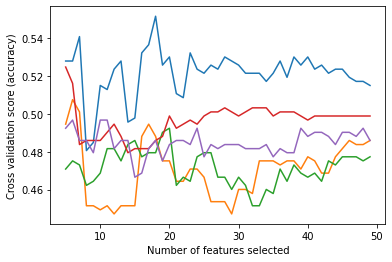

Optimal number of features:  13
      Feature  Ranking
48     Ultosc        1
28      Mom10        1
32     Slow_d        1
33     Fast_k        1
25   Lower_bb        1
36  William_R        1
40       Macd        1
34     Fast_d        1
5       Sp500        1
45        Cci        1
1       Close        1
42        Apo        1
23   Upper_bb        1


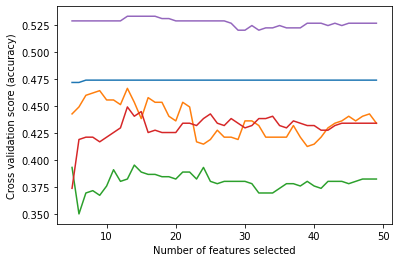

Optimal number of features:  5
     Feature  Ranking
0       Open        1
23  Upper_bb        1
25  Lower_bb        1
4     Down-F        1
8       Gold        1


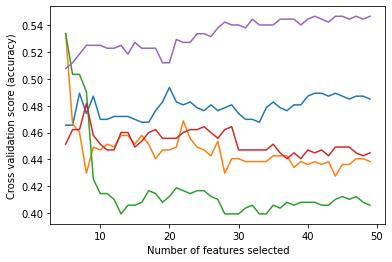

In [387]:

# Fill missing values, do some scaling (run prev cell first)
list_df = []

for df in [aapl_df, msft_df, amzn_df]:
    columns = df.columns
    df.fillna(0, inplace=True) # fill na with 0
    y = df["MOVEMENT"].copy()
    X = df.drop(columns=["MOVEMENT"]).copy()
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X))
    X["MOVEMENT"] = np.array(y)
    X.columns = columns
    list_df.append(X)
    
aapl_df_full = list_df[0]
msft_df_full = list_df[1]
amzn_df_full = list_df[2]

# #Columns RFE + PCA with the columns of high ranking feature classified using RFE in Data Exploration.ipynb
# list_df_pca = []

columns_pca = [
    "Open", "Close", "Adj Close", "Lower_bb",
    "Sma", "Macd" 
]

# # columns_pca = [
# #     "Mom5", "Mom20", "Volume", "Fast_k",
# #     "Nat_Gas", "Cci", 'Ultosc'
# # ]

for df in [aapl_df_full, msft_df_full, amzn_df_full]:
    cur_df = df.copy()
    cur_df = feature_select(cur_df , 5)
    pca = PCA(n_components= 1)
    y = df["MOVEMENT"].copy()
    X = df.drop(columns=["MOVEMENT"]).copy()
    reduced_X = pd.DataFrame(pca.fit_transform(X))
    reduced_X["MOVEMENT"] = y
    list_df_pca.append(reduced_X)

aapl_df_pca = list_df_pca[0]
msft_df_pca = list_df_pca[1]
amzn_df_pca = list_df_pca[2]

#### Full features

In [392]:

aapl_df_full = list_df_pca[0]
msft_df_full = list_df_pca[1]
amzn_df_full = list_df_pca[2]

# #Ingnore movement column
nf = amzn_df_full.shape[1] - 1

In [393]:
aapl_df_full

,0,MOVEMENT
0,-2.916580,0
1,-2.943574,1
2,-2.926497,0
3,-2.918986,0
4,-2.930478,1
...,...,...
2311,7.162444,1
2312,7.219703,1
2313,7.341022,0
2314,7.431214,1


In [284]:
### aapl
# Split
X = np.array(aapl_df_full.drop(columns=["MOVEMENT"]).copy())
y = np.array(aapl_df_full["MOVEMENT"].copy())

In [285]:
# Split train test, should not shuffle as the data is time series
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False , random_state = 32
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=False , random_state = 32
)

In [286]:
# Get input ready for lstm
win_length = 30
batch_size = 32
num_features = nf
train_generator = TimeseriesGenerator(np.array(X_train), np.array(y_train),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

test_generator = TimeseriesGenerator(np.array(X_test), np.array(y_test),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

valid_generator = TimeseriesGenerator(np.array(X_valid), np.array(y_valid),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

In [273]:
model_gru = gru(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model_gru.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model_gru.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

Epoch 1/100
65/65 [==============================] - 6s 55ms/step - loss: 0.6945 - acc: 0.4956 - f1: 0.3567 - val_loss: 0.6928 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 2/100
65/65 [==============================] - 3s 43ms/step - loss: 0.6936 - acc: 0.5034 - f1: 0.3574 - val_loss: 0.6930 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 3/100
65/65 [==============================] - 3s 42ms/step - loss: 0.6931 - acc: 0.5185 - f1: 0.3695 - val_loss: 0.6927 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 4/100
65/65 [==============================] - 3s 43ms/step - loss: 0.6932 - acc: 0.5127 - f1: 0.3587 - val_loss: 0.6926 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 5/100
65/65 [==============================] - 3s 44ms/step - loss: 0.6931 - acc: 0.5170 - f1: 0.3614 - val_loss: 0.6926 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 6/100
65/65 [==============================] - 3s 41ms/step - loss: 0.6928 - acc: 0.5146 - f1: 0.3743 - val_loss: 0.6928 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 7/100
65/65 [=========

In [277]:
model = lstm(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

Epoch 1/100
65/65 [==============================] - 8s 49ms/step - loss: 0.9834 - acc: 0.4873 - f1: 0.3447 - val_loss: 0.7012 - val_acc: 0.4860 - val_f1: 0.3253
Epoch 2/100
65/65 [==============================] - 2s 29ms/step - loss: 0.7655 - acc: 0.4810 - f1: 0.3513 - val_loss: 0.6980 - val_acc: 0.5028 - val_f1: 0.3290
Epoch 3/100
65/65 [==============================] - 2s 31ms/step - loss: 0.7418 - acc: 0.4893 - f1: 0.3650 - val_loss: 0.6962 - val_acc: 0.5028 - val_f1: 0.3498
Epoch 4/100
65/65 [==============================] - 2s 29ms/step - loss: 0.7260 - acc: 0.4786 - f1: 0.3687 - val_loss: 0.6949 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 5/100
65/65 [==============================] - 2s 28ms/step - loss: 0.7119 - acc: 0.4849 - f1: 0.3903 - val_loss: 0.6937 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 6/100
65/65 [==============================] - 2s 31ms/step - loss: 0.7060 - acc: 0.4825 - f1: 0.3847 - val_loss: 0.6933 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 7/100
65/65 [=========

In [275]:
result_aapl_full = model_gru.predict(test_generator)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_full, y_test[win_length:])}")
print(f"aapl F1: {f1_score(result_aapl_full, y_test[win_length:], average='macro')}")

aapl Accuracy: 0.5643564356435643
aapl F1: 0.36075949367088606


In [278]:
result_aapl_full = model.predict(test_generator)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"aapl Accuracy: {accuracy_score(result_aapl_full, y_test[win_length:])}")
print(f"aapl F1: {f1_score(result_aapl_full, y_test[win_length:], average='macro')}")

aapl Accuracy: 0.5594059405940595
aapl F1: 0.36881648702734965


In [295]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predict = clf.predict(X_test)

print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
# print(f'Train Score : {model.score(X_train, y_train) * 100:.2f}% and Test Score : {model.score(X_test, y_test) * 100:.2f}% using Random Tree Regressor.')

print('Accuracy:', metrics.accuracy_score(predict , y_test) , '%.')


Mean Absolute Error: 0.5647
Mean Squared Error: 0.5647
Root Mean Squared Error: 0.7514
(R^2) Score: -1.3143
Accuracy: 0.4353448275862069 %.


In [304]:
### msft
# Split
X = np.array(msft_df_full.drop(columns=["MOVEMENT"]).copy())
y = np.array(msft_df_full["MOVEMENT"].copy())

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X)
X = scaler.transform(X)

In [305]:
# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False , random_state = 32
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=False , random_state = 32
)

In [306]:
# Get input ready for lstm
win_length = 30
batch_size = 32
num_features = nf
train_generator = TimeseriesGenerator(np.array(X_train), np.array(y_train),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

test_generator = TimeseriesGenerator(np.array(X_test), np.array(y_test),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

valid_generator = TimeseriesGenerator(np.array(X_valid), np.array(y_valid),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

In [300]:
model_gru = gru(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model_gru.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model_gru.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

Epoch 1/100
58/58 [==============================] - 7s 64ms/step - loss: 0.6953 - acc: 0.4878 - f1: 0.3496 - val_loss: 0.6928 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 2/100
58/58 [==============================] - 3s 48ms/step - loss: 0.6938 - acc: 0.5046 - f1: 0.3822 - val_loss: 0.6927 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 3/100
58/58 [==============================] - 2s 40ms/step - loss: 0.6937 - acc: 0.4911 - f1: 0.3702 - val_loss: 0.6927 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 4/100
58/58 [==============================] - 2s 41ms/step - loss: 0.6933 - acc: 0.5041 - f1: 0.3775 - val_loss: 0.6927 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 5/100
58/58 [==============================] - 2s 43ms/step - loss: 0.6934 - acc: 0.5117 - f1: 0.3840 - val_loss: 0.6928 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 6/100
58/58 [==============================] - 2s 40ms/step - loss: 0.6935 - acc: 0.5106 - f1: 0.3825 - val_loss: 0.6926 - val_acc: 0.5196 - val_f1: 0.3407
Epoch 7/100
58/58 [=========

In [210]:
model = lstm(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

Epoch 1/100
58/58 [==============================] - 8s 48ms/step - loss: 0.8324 - acc: 0.5068 - f1: 0.3893 - val_loss: 0.7012 - val_acc: 0.5251 - val_f1: 0.3891
Epoch 2/100
58/58 [==============================] - 2s 28ms/step - loss: 0.7005 - acc: 0.5165 - f1: 0.4152 - val_loss: 0.7002 - val_acc: 0.5363 - val_f1: 0.3745
Epoch 3/100
58/58 [==============================] - 2s 27ms/step - loss: 0.7013 - acc: 0.5024 - f1: 0.4006 - val_loss: 0.6980 - val_acc: 0.5419 - val_f1: 0.3516
Epoch 4/100
58/58 [==============================] - 2s 28ms/step - loss: 0.7008 - acc: 0.5041 - f1: 0.3967 - val_loss: 0.6972 - val_acc: 0.5419 - val_f1: 0.3516
Epoch 5/100
58/58 [==============================] - 2s 27ms/step - loss: 0.6984 - acc: 0.4976 - f1: 0.3922 - val_loss: 0.6982 - val_acc: 0.5419 - val_f1: 0.3516
Epoch 6/100
58/58 [==============================] - 2s 28ms/step - loss: 0.6969 - acc: 0.5035 - f1: 0.3902 - val_loss: 0.6994 - val_acc: 0.5419 - val_f1: 0.3516
Epoch 7/100
58/58 [=========

In [301]:
result_aapl_full = model_gru.predict(test_generator)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_aapl_full, y_test[win_length:])}")
print(f"msft F1: {f1_score(result_aapl_full, y_test[win_length:], average='macro')}")

msft Accuracy: 0.5643564356435643
msft F1: 0.36075949367088606


In [212]:
result_aapl_full = model.predict(test_generator)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"msft Accuracy: {accuracy_score(result_aapl_full, y_test[win_length:])}")
print(f"msft F1: {f1_score(result_aapl_full, y_test[win_length:], average='macro')}")

msft Accuracy: 0.6039603960396039
msft F1: 0.37654320987654316


In [308]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predict = clf.predict(X_test)

print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
# print(f'Train Score : {model.score(X_train, y_train) * 100:.2f}% and Test Score : {model.score(X_test, y_test) * 100:.2f}% using Random Tree Regressor.')

print('Accuracy:', metrics.accuracy_score(predict , y_test) , '%.')


Mean Absolute Error: 0.5431
Mean Squared Error: 0.5431
Root Mean Squared Error: 0.737
(R^2) Score: -1.2613
Accuracy: 0.45689655172413796 %.


In [420]:
### amzn
# Split
X = np.array(amzn_df_full.drop(columns=["MOVEMENT"]).copy())
y = np.array(amzn_df_full["MOVEMENT"].copy())

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X)
X = scaler.transform(X)

In [421]:
# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False , random_state = 32
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=False , random_state = 32
)

In [422]:
# Get input ready for lstm
win_length = 30
batch_size = 32
num_features = nf
train_generator = TimeseriesGenerator(np.array(X_train), np.array(y_train),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

test_generator = TimeseriesGenerator(np.array(X_test), np.array(y_test),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

valid_generator = TimeseriesGenerator(np.array(X_valid), np.array(y_valid),
                                     length=win_length,
                                     sampling_rate=1,
                                     batch_size=batch_size)

In [423]:
model_gru = gru(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model_gru.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model_gru.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

Epoch 1/100
58/58 [==============================] - 7s 80ms/step - loss: 0.6923 - acc: 0.5209 - f1: 0.3706 - val_loss: 0.6866 - val_acc: 0.5587 - val_f1: 0.3575
Epoch 2/100
58/58 [==============================] - 4s 69ms/step - loss: 0.6919 - acc: 0.5295 - f1: 0.3476 - val_loss: 0.6890 - val_acc: 0.5587 - val_f1: 0.3575
Epoch 3/100
58/58 [==============================] - 4s 70ms/step - loss: 0.6911 - acc: 0.5295 - f1: 0.3503 - val_loss: 0.6884 - val_acc: 0.5587 - val_f1: 0.3575
Epoch 4/100
58/58 [==============================] - 4s 71ms/step - loss: 0.6919 - acc: 0.5279 - f1: 0.3677 - val_loss: 0.6869 - val_acc: 0.5587 - val_f1: 0.3575
Epoch 5/100
58/58 [==============================] - 4s 71ms/step - loss: 0.6913 - acc: 0.5230 - f1: 0.3529 - val_loss: 0.6878 - val_acc: 0.5587 - val_f1: 0.3575
Epoch 6/100
58/58 [==============================] - 4s 69ms/step - loss: 0.6909 - acc: 0.5290 - f1: 0.3569 - val_loss: 0.6876 - val_acc: 0.5587 - val_f1: 0.3575
Epoch 7/100
58/58 [=========

In [424]:
model = lstm(win_length, num_features)

optimizer = keras.optimizers.Adam()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=20,
                                                 mode="min")
model.compile(optimizer=optimizer, loss="binary_crossentropy", 
                   metrics=["acc", f1])
model.fit_generator(train_generator,
                   epochs=100,
                   validation_data=valid_generator,
                   shuffle=False, callbacks=[early_stopping])

Epoch 1/100
58/58 [==============================] - 8s 68ms/step - loss: 8.1765 - acc: 0.4699 - f1: 0.3179 - val_loss: 8.6173 - val_acc: 0.4413 - val_f1: 0.3004
Epoch 2/100
58/58 [==============================] - 3s 48ms/step - loss: 8.1765 - acc: 0.4699 - f1: 0.3179 - val_loss: 8.6173 - val_acc: 0.4413 - val_f1: 0.3004
Epoch 3/100
58/58 [==============================] - 3s 49ms/step - loss: 8.1765 - acc: 0.4699 - f1: 0.3179 - val_loss: 8.6173 - val_acc: 0.4413 - val_f1: 0.3004
Epoch 4/100
58/58 [==============================] - 3s 49ms/step - loss: 8.1765 - acc: 0.4699 - f1: 0.3179 - val_loss: 8.6173 - val_acc: 0.4413 - val_f1: 0.3004
Epoch 5/100
58/58 [==============================] - 3s 47ms/step - loss: 8.1765 - acc: 0.4699 - f1: 0.3179 - val_loss: 8.6173 - val_acc: 0.4413 - val_f1: 0.3004
Epoch 6/100
58/58 [==============================] - 3s 47ms/step - loss: 8.1765 - acc: 0.4699 - f1: 0.3179 - val_loss: 8.6173 - val_acc: 0.4413 - val_f1: 0.3004
Epoch 7/100
58/58 [=========

In [425]:
result_aapl_full = model_gru.predict(test_generator)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_aapl_full, y_test[win_length:])}")
print(f"amzn F1: {f1_score(result_aapl_full, y_test[win_length:], average='macro')}")

amzn Accuracy: 0.5297029702970297
amzn F1: 0.34627831715210355


In [426]:
result_aapl_full = model.predict(test_generator)
result_aapl_full = (result_aapl_full > 0.5).astype(int)
print(f"amzn Accuracy: {accuracy_score(result_aapl_full, y_test[win_length:])}")
print(f"amzn F1: {f1_score(result_aapl_full, y_test[win_length:], average='macro')}")

amzn Accuracy: 0.47029702970297027
amzn F1: 0.31986531986531985


In [432]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# Split train test, should not shuffle as the data is time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predict = clf.predict(X_test)

print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
# print(f'Train Score : {model.score(X_train, y_train) * 100:.2f}% and Test Score : {model.score(X_test, y_test) * 100:.2f}% using Random Tree Regressor.')

print('Accuracy:', metrics.accuracy_score(predict , y_test) , '%.')


Mean Absolute Error: 0.4353
Mean Squared Error: 0.4353
Root Mean Squared Error: 0.6598
(R^2) Score: -0.7477
Accuracy: 0.5646551724137931 %.


In [428]:
# #Full feature

# aapl Accuracy: 0.44
# aapl F1: 0.41

# msft Accuracy: 0.57
# msft F1: 0.50

# amzn Accuracy: 0.45
# amzn F1: 0.44

# #45,53,49

In [429]:
# PCA

# aapl Accuracy: 0.47093023255813954
# aapl F1: 0.45545002261420175

# msft Accuracy: 0.563953488372093
# msft F1: 0.3944514857062385

# amzn Accuracy: 0.4883720930232558
# amzn F1: 0.4649321266968325

In [430]:
# aapl Accuracy: 0.5581395348837209
# aapl F1: 0.4509408602150538

# msft Accuracy: 0.5581395348837209
# msft F1: 0.3810606060606061

# amzn Accuracy: 0.5
# amzn F1: 0.3333333333333333

In [431]:
#RFECV 7 FEATURE LOGISTIC REGRESSION

# aapl Accuracy: 0.45348837209302323
# aapl F1: 0.4443986254295532


# msft Accuracy: 0.5290697674418605
# msft F1: 0.49767441860465117

# amzn Accuracy: 0.5116279069767442
# amzn F1: 0.40786885245901644

#RFE DecisionTreeClassifier 

# aapl Accuracy: 0.45348837209302323
# aapl F1: 0.3937303134843258

# msft Accuracy: 0.48255813953488375
# msft F1: 0.4023814171383955

# amzn Accuracy: 0.4883720930232558
# amzn F1: 0.48135964912280693

#Anova -F score

# aapl Accuracy: 0.47674418604651164
# aapl F1: 0.4695723684210526

# msft Accuracy: 0.47093023255813954
# msft F1: 0.45951172347111435

# amzn Accuracy: 0.5
# amzn F1: 0.47434257285003556

